# Traffic tracker counting demo

This notebook will cover the absolute basics of converting the traffic tracker object paths output into useful count data. This notebook will use the data generated from the following command:

`python main.py -video data/videos/highway_02.mp4 -display -nframes 250 -threshold 0.4`

After which the `output_paths.txt` has been renamed `object_paths_highway02_pednet.txt`

**Note: this code is ugly and specifically simplified for this example tutorial. It is far from optimal...**

### Import dependencies

In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

### Read in data

In [3]:
# load object paths
df = pd.read_csv('object_paths_highway02_pednet.txt', header=None, names=['frame', 'time', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'class','score'])
df.shape

(1539, 9)

In [4]:
df.sample(5)

,frame,time,id,bb_left,bb_top,bb_width,bb_height,class,score
106,14,1587761586,11.0,748.898648,320.820240,47.394645,25.696894,car,0.917969
1434,230,1587761885,97.0,507.966330,382.495359,44.674279,39.019107,car,0.992188
1227,197,1587761840,93.0,929.060437,508.693997,105.908073,97.151064,car,0.996094
1030,158,1587761787,83.0,740.762562,334.294593,51.558991,31.758036,car,0.917969
161,21,1587761596,10.0,829.843079,575.076657,151.035433,154.578934,car,0.769531


In [5]:
#  compute detection centroids
df['cx'] = df['bb_left'] + (0.5 * df['bb_width'])
df['cy'] = df['bb_top']  + (0.5 * df['bb_height'])

In [6]:
# load helper image
IMG_PATH = 'highway02_frame000010.jpg'
pil_img = Image.open(IMG_PATH)

### Analysis

In [7]:
# first, lets create a path which if crossed, will increment our counters
gates = [
    [(150,500), (600,500)],    # (xy1, xy2)
    [(700,500), (1150,500)],   # (xy1, xy2)
]

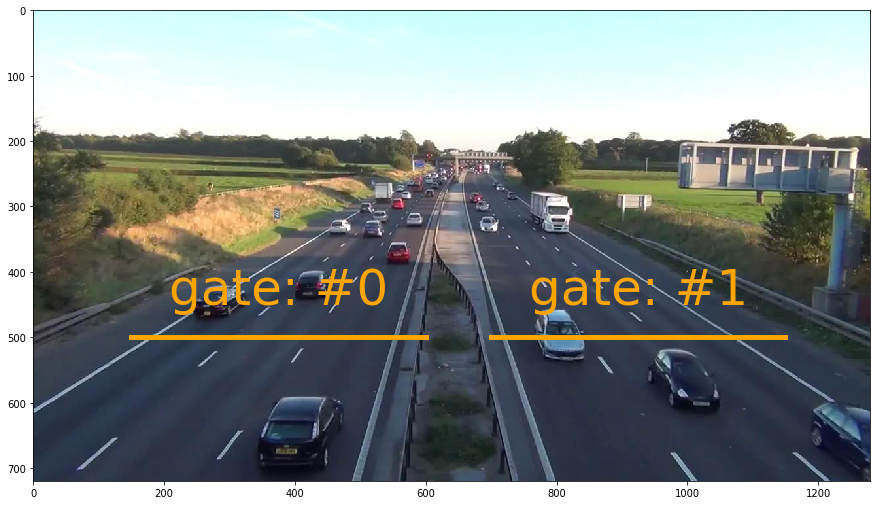

In [8]:
# let's validate that these gates are in the right place with a plot
fig, ax = plt.subplots(figsize=(15,15))
plt.imshow(pil_img)

for g, gate in enumerate(gates):
    x1, y1 = gate[0]
    x2, y2 = gate[1]
    x, y = [x1, x2], [y1, y2]
    plt.plot(x, y, color='orange', linewidth=5)

    plt.text(
        sum(x)/2,
        sum(y)/2 - 50, 
        f"gate: #{g}", 
        color='orange', 
        horizontalalignment='center',
        fontsize=50)
        
ax.set_aspect('equal')
plt.show()

The easiest way to get traffic counts from this point is to simply look at the time-dependent trajectory of each object and see if it crosses any of the gates. This means we need to create a simple function, which when given two line segments will return `True` if they cross and `False` if they don't or are only touching.

In [9]:
def ccw(a, b, c):
    return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

In [10]:
def cross(s1, s2):
    a, b = s1
    c, d = s2
    return ccw(a, c, d) != ccw(b, c, d) and ccw(a, b, c) != ccw(a, b, d)

In [11]:
# now lets cycle throught each objects trajectory and determine if it has crossed either of the gates
gate_counts_dict = defaultdict(int)
for n, obj_path in df.groupby(by='id'):
    
    # cycle through each time step of trajectory in ascending order
    for i, row in obj_path.sort_values(by='time', ascending=True).iterrows():
    
        # get position at current time
        xy_t0 = tuple(row[['cx', 'cy']].values)
        
        # get position at most recent historic time step
        xy_t1 = obj_path[ obj_path['frame'] < row['frame']].sort_values(by='frame', ascending=False)
        
        # if a previous time step is found, let's check if it crosses any of the gates
        if xy_t1.shape[0]>0:
            xy_t1 = tuple(xy_t1[['cx', 'cy']].values[0])
            
            # cycle through gates
            for g, gate in enumerate(gates):
                gate_counts_dict[g] += cross(gates[g], [xy_t0, xy_t1])        

In [12]:
# print some results
for k, v in gate_coforunts_dict.items():
    print(f'GATE {k}: {v}')

GATE 0: 11
GATE 1: 16
